Select target genes and transcripts using sequencing data.

In [1]:
# Download the single-cell sequencing data
!mkdir temporary_data
!mkdir temporary_data/example_select_target_genes
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/matrix.mtx.gz -O temporary_data/example_select_target_genes/matrix.mtx.gz
!gzip -d temporary_data/example_select_target_genes/matrix.mtx.gz -f
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/features.tsv.gz -O temporary_data/example_select_target_genes/features.tsv.gz
!gzip -d temporary_data/example_select_target_genes/features.tsv.gz -f
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/cluster.membership.csv -O temporary_data/example_select_target_genes/cluster.membership.csv
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/cluster.annotation.csv -O temporary_data/example_select_target_genes/cluster.annotation.csv
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/barcode.tsv -O temporary_data/example_select_target_genes/barcode.tsv

mkdir: cannot create directory ‘temporary_data’: File exists
--2021-08-11 14:17:16--  https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/matrix.mtx.gz
Resolving data.nemoarchive.org (data.nemoarchive.org)... 134.192.156.26
Connecting to data.nemoarchive.org (data.nemoarchive.org)|134.192.156.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2966947337 (2.8G) [application/x-gzip]
Saving to: ‘temporary_data/example_select_target_genes/matrix.mtx.gz’

temporary_data/exam 100%[===================>]   2.76G  46.4MB/s    in 59s     

2021-08-11 14:18:15 (48.2 MB/s) - ‘temporary_data/example_select_target_genes/matrix.mtx.gz’ saved [2966947337/2966947337]

--2021-08-11 14:19:13--  https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/features.tsv.gz
Resolving data.nemoarchive.org (data.nemoarchive.org)... 134.192.156.26
Con

In [2]:
# Input files
mtx_file = 'temporary_data/example_select_target_genes/matrix.mtx'
features_file = 'temporary_data/example_select_target_genes/features.tsv'
barcode_file = 'temporary_data/example_select_target_genes/barcode.tsv'
clusters_file = 'temporary_data/example_select_target_genes/cluster.membership.csv'
clusters_annotation_file = 'temporary_data/example_select_target_genes/cluster.annotation.csv'

# Output files
selected_genes_file = 'temporary_data/example_select_target_genes/target_genes.csv'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

# Load and preprocess scRNA-seq data

In [4]:
%%time
adata = sc.read_mtx(mtx_file)
adata = adata.transpose() # The matrix has to be transposed because the genes and cells are fipped

CPU times: user 18min 7s, sys: 18.1 s, total: 18min 25s
Wall time: 18min 14s


In [5]:
# Load gene names
features = pd.read_csv(features_file, sep='\t', header=None)
adata.var['gene_ids'] = list(features[0])
adata.var['gene_symbols'] = list(features[1])
adata.var = adata.var.set_index('gene_symbols')
adata.var_names_make_unique()

# Load cell IDs (barcodes)
barcodes = pd.read_csv(barcode_file, sep=',').rename(columns={'x':'barcode'}).drop(columns='Unnamed: 0')
adata.obs = barcodes.set_index('barcode')

# Load clusters
clusters = pd.read_csv(clusters_file, sep=',').rename(columns={'x':'cluster', 'Unnamed: 0':'barcode'})
cluster_annotation = pd.read_csv(clusters_annotation_file, sep=',')
clusters = clusters.merge(cluster_annotation, left_on='cluster', right_on='cluster_id')

# Keep all the cells with assigned clusters
adata = adata[adata.obs.index.isin(clusters['barcode'])]
adata.obs = adata.obs.merge(clusters, left_index=True, right_on='barcode').set_index('barcode')

# Remove all cells marked as low quality
adata = adata[adata.obs['class_label'] != 'Low Quality']
adata

View of AnnData object with n_obs × n_vars = 71183 × 31053
    obs: 'cluster', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size'
    var: 'gene_ids'

In [6]:
# Calculate gene expression levels in the most highly expressed cell types
cluster_labels = np.unique(adata.obs['cluster_label'])

gene_max_mean_cluster_counts = np.zeros(adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(adata.X[adata.obs['cluster_label'] == cl], axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

Trying to set attribute `.var` of view, copying.


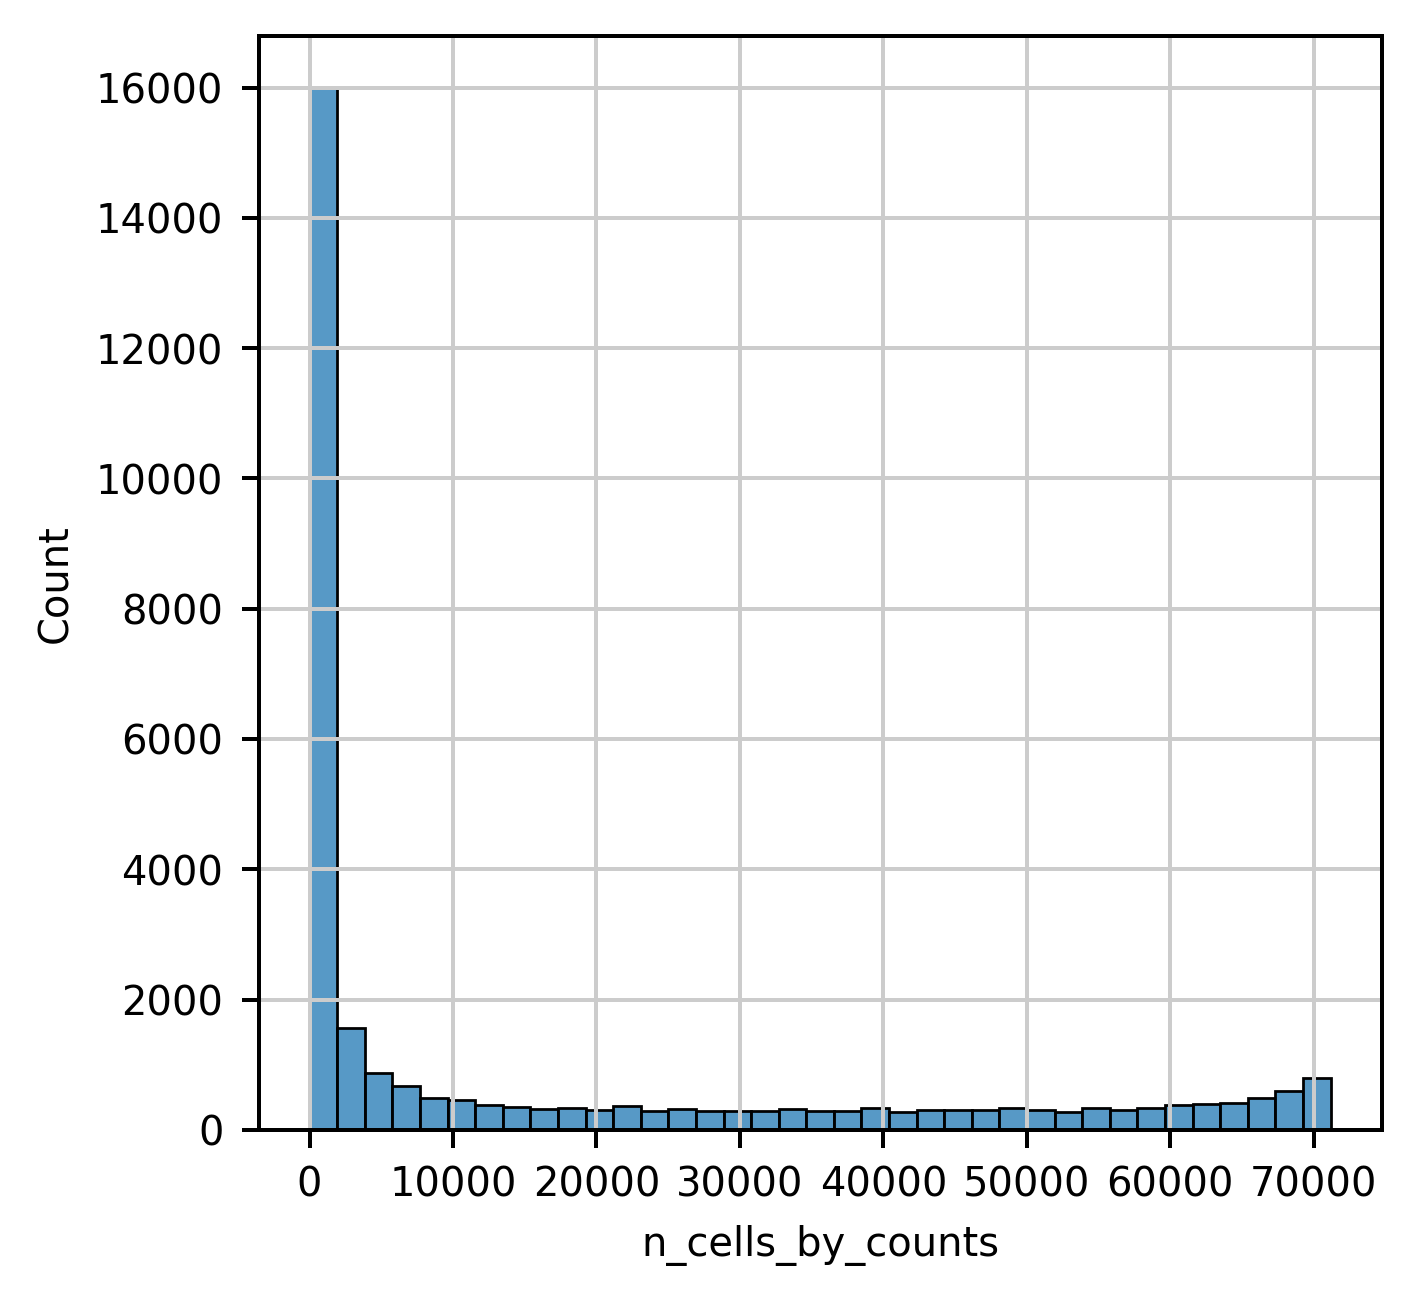

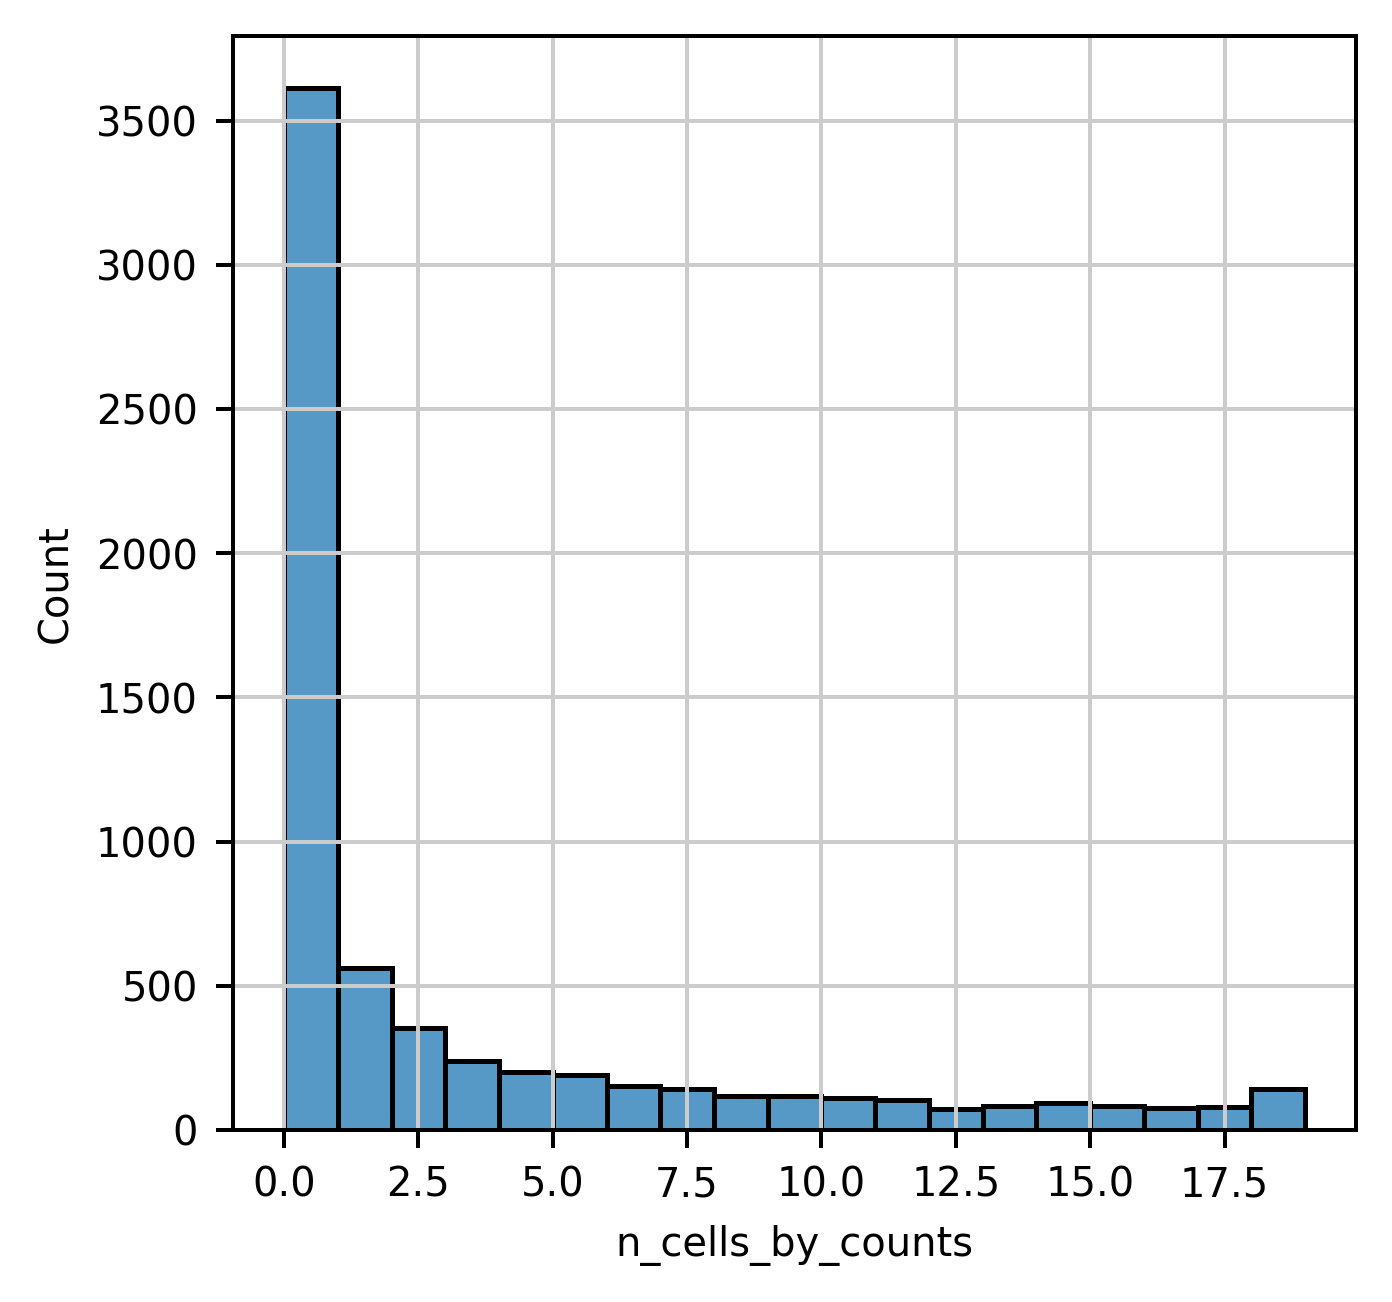

View of AnnData object with n_obs × n_vars = 71183 × 25252
    obs: 'cluster', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'max_mean_cluster_count', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [7]:
# Quality control
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Plot the number of cells in which each gene is expressed
sns.histplot(data=adata.var, x='n_cells_by_counts')
plt.show()
sns.histplot(data=adata.var, x='n_cells_by_counts', bins=list(range(20)))
plt.show()

# Filter out genes that are only expressed in few cells
adata = adata[:, adata.var['n_cells_by_counts'] > 10]
adata_raw = adata.copy()
adata

In [8]:
# Preprocess
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... storing 'cluster_label' as categorical
... storing 'subclass_label' as categorical
... storing 'class_label' as categorical
... storing 'cluster_color' as categorical


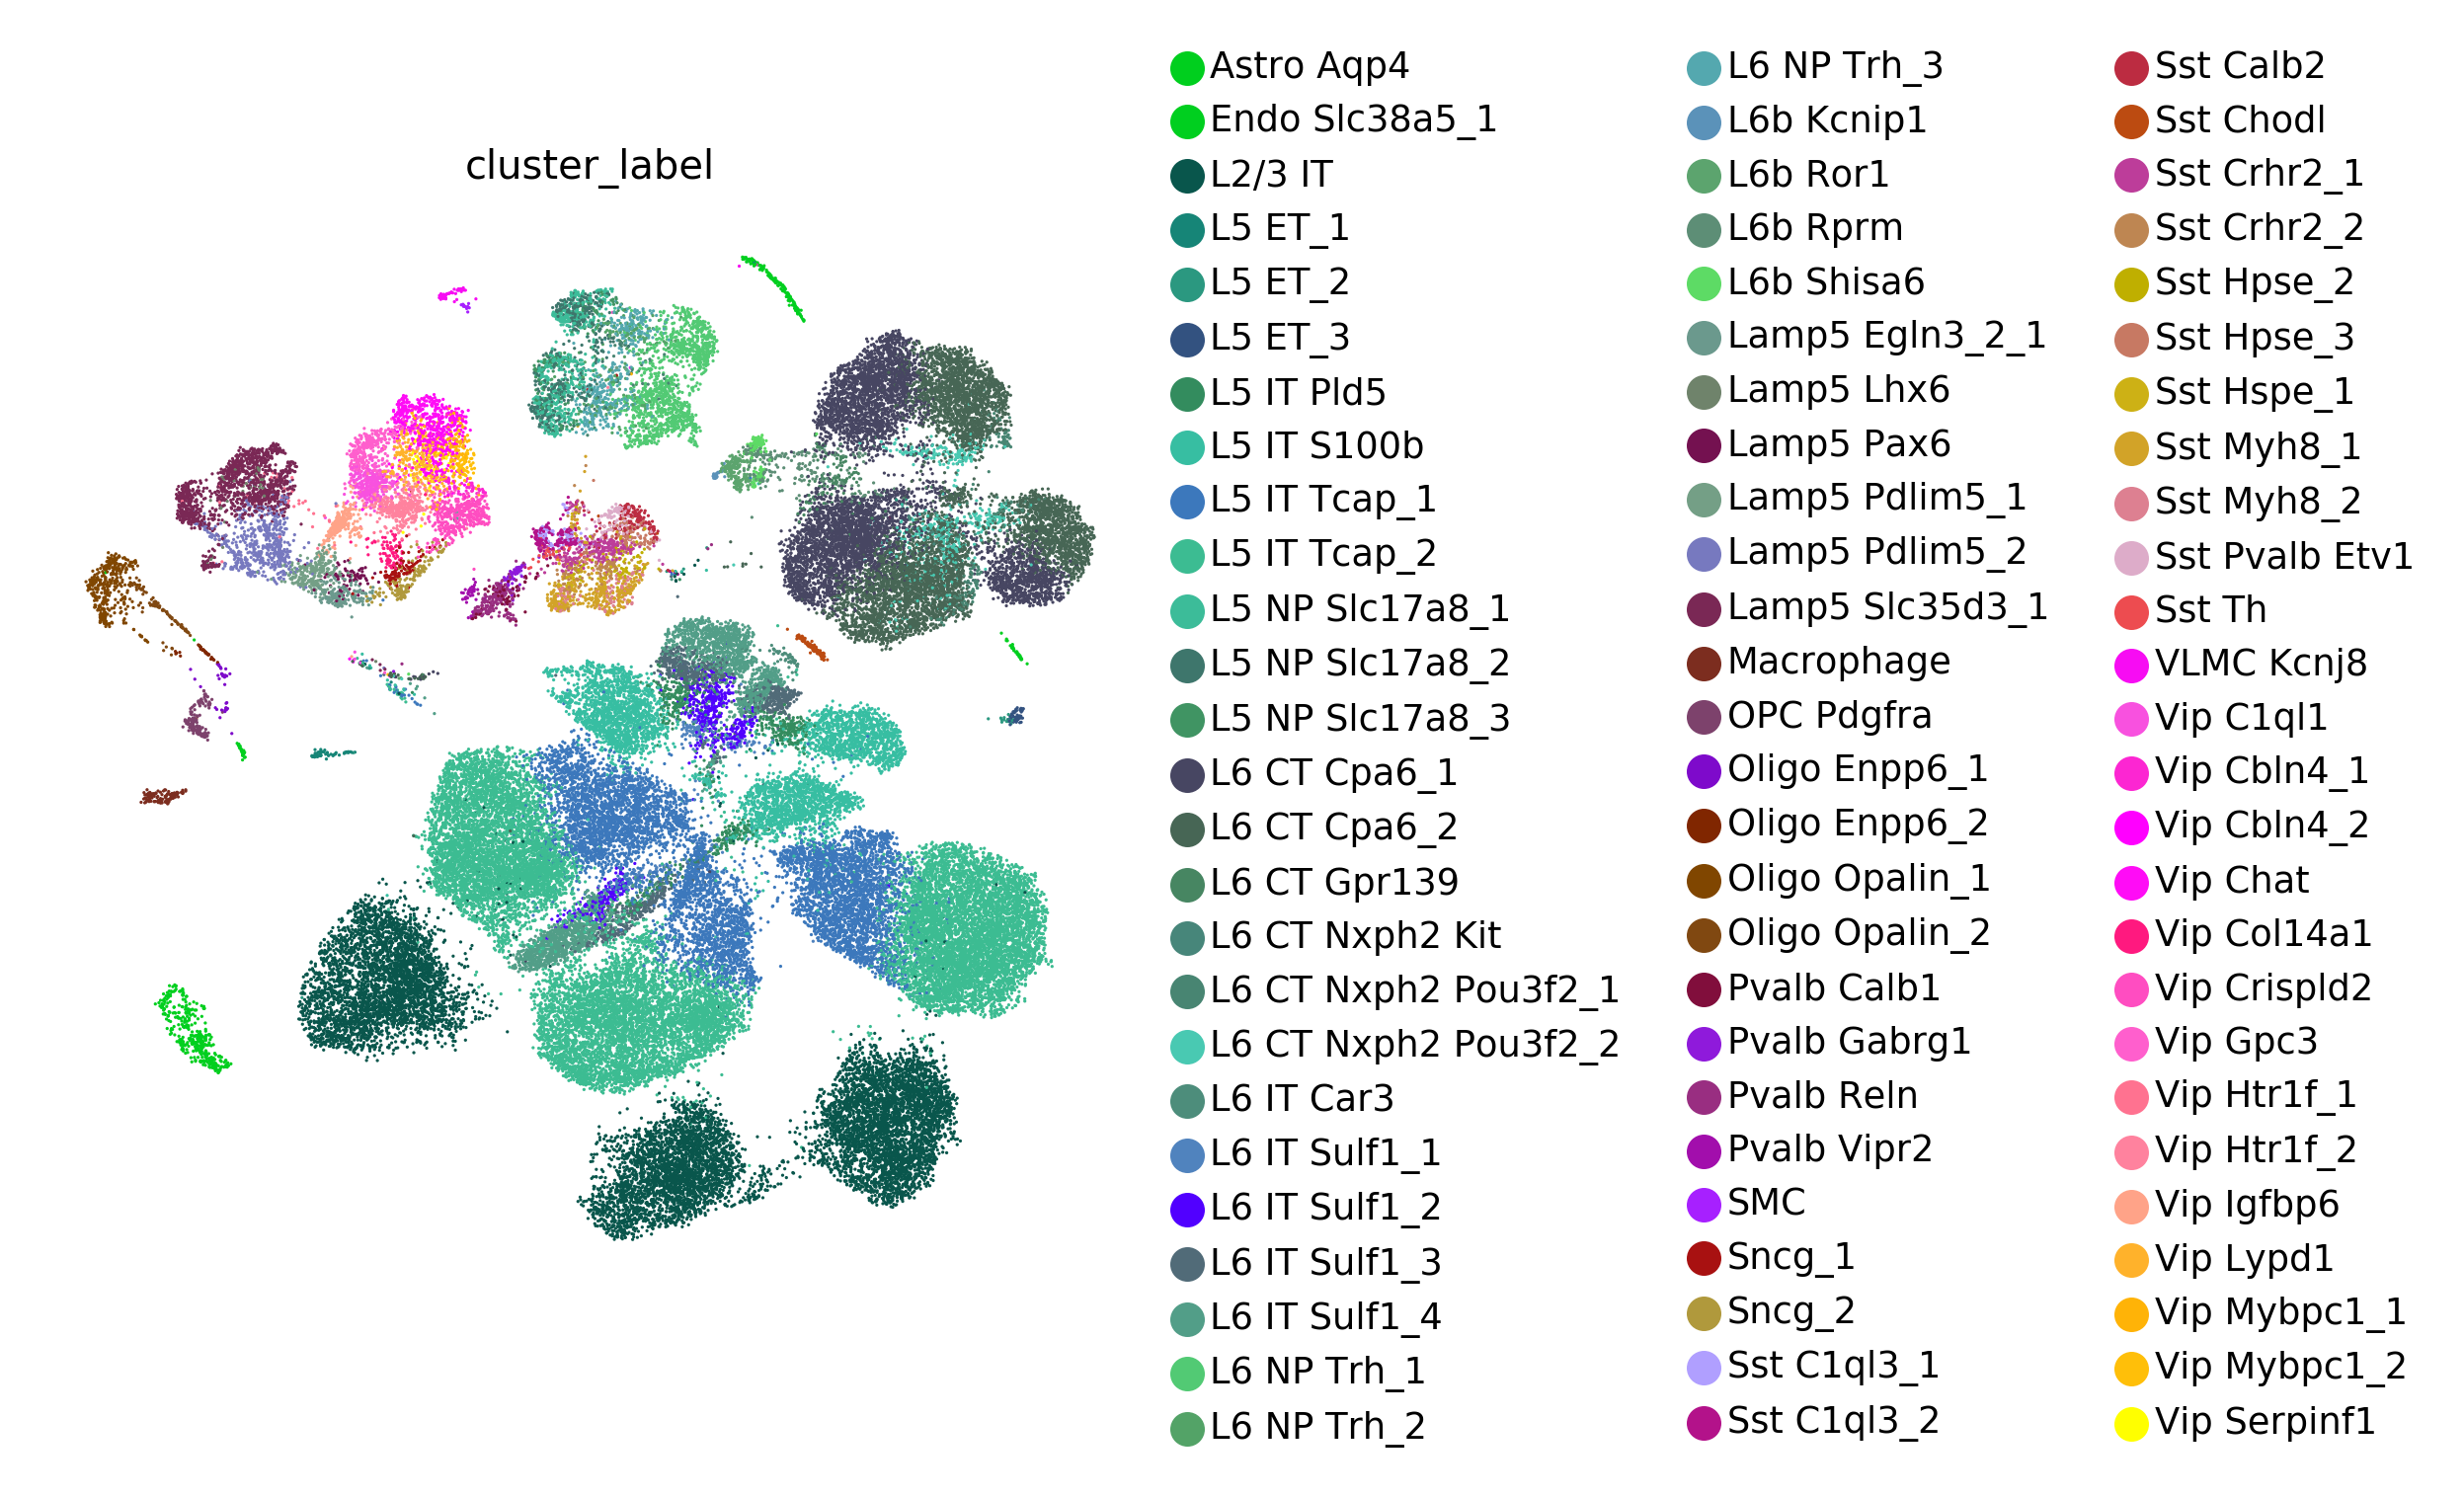

CPU times: user 24min 40s, sys: 9min 22s, total: 34min 3s
Wall time: 1min 38s


In [9]:
%%time
# Plot the clusters onto UMAP
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Embed with UMAP
sc.tl.umap(adata)
# Set the colors for plotting clusters
adata.uns['cluster_label_colors'] = np.unique(adata.obs['cluster_color'])
# Plot the clusters (it seems that there are some batch effect in this dataset)
sc.pl.umap(adata, color='cluster_label')

# Select target genes

In [10]:
# Filter the genes by gene type and expression level
filtered_genes = np.array(adata.var.index)

# Remove the highly expressed genes that may cause over-crowding in MERFISH
percentile_threshold = 99
mask1 = adata.var['mean_counts'] < np.percentile(adata.var['mean_counts'], percentile_threshold)
mask2 = adata.var['max_mean_cluster_count'] < np.percentile(adata.var['max_mean_cluster_count'], percentile_threshold)
mask = mask1 & mask2
filtered_genes = filtered_genes[mask]

# Remove all mitochondrial genes
mask = [not g.lower().startswith('mt-') for g in filtered_genes]
filtered_genes = filtered_genes[mask]

In [11]:
%%time
# Select the marker genes
adata_filtered = adata_raw[:, adata_raw.var.index.isin(filtered_genes)]
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata_filtered)

# Define the marker genes as the differentially expressed genes
sc.tl.rank_genes_groups(adata_filtered, 'cluster_label', method='wilcoxon')

# Select the top marker genes
N_genes_to_select = 200
marker_genes = set()

for i in range(len(adata_filtered.uns['rank_genes_groups']['names'])):
    new_markers = set(adata_filtered.uns['rank_genes_groups']['names'][i])
    
    for m in new_markers:
        marker_genes.add(m)
        if len(marker_genes) >= N_genes_to_select:
            break
            
    if len(marker_genes) >= N_genes_to_select:
            break

marker_genes = np.array(list(marker_genes))
print(f'Found {len(marker_genes)} marker genes.')

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'cluster_label' as categorical
... storing 'subclass_label' as categorical
... storing 'class_label' as categorical
... storing 'cluster_color' as categorical


Found 200 marker genes.
CPU times: user 6min 23s, sys: 32.3 s, total: 6min 55s
Wall time: 6min 55s


In [12]:
selected_genes = marker_genes

# Validate selected genes

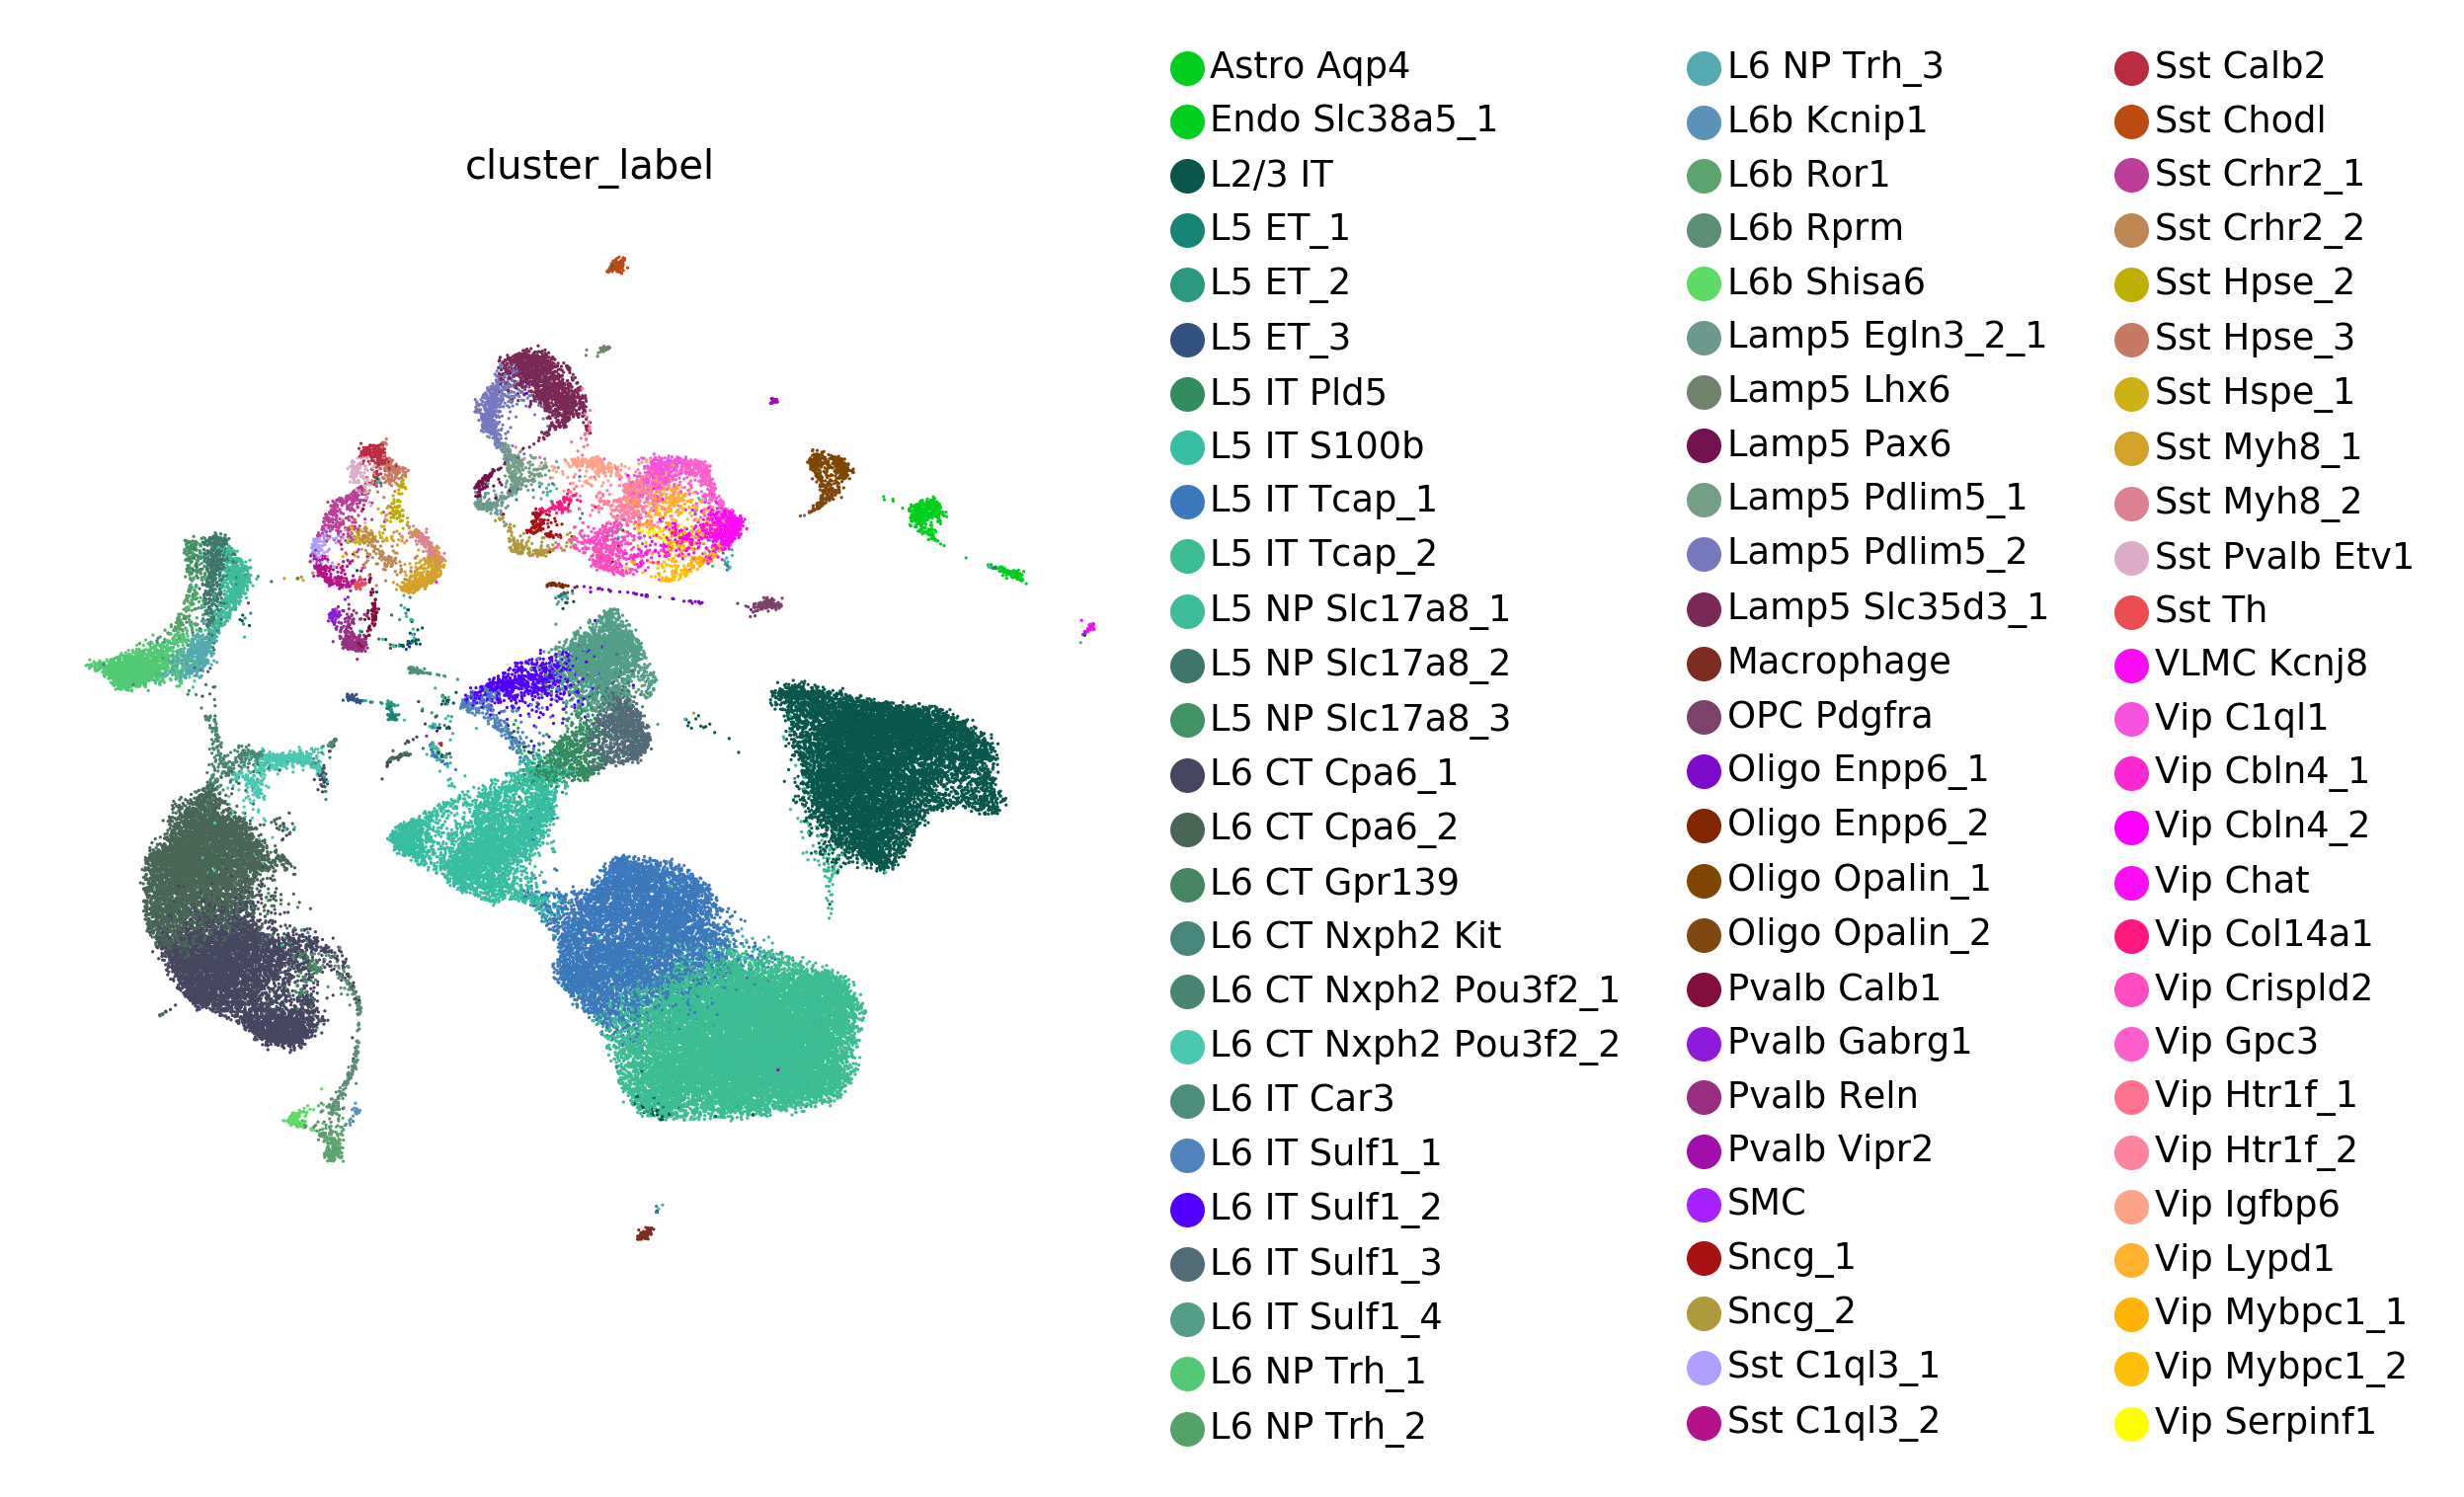

CPU times: user 3min 54s, sys: 3min 13s, total: 7min 7s
Wall time: 42 s


In [13]:
%%time
# Validate that the selected genes recapitulate the cluster structures
adata_selected = adata[:, adata.var.index.isin(selected_genes)]
# Principal component analysis
sc.tl.pca(adata_selected, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata_selected, n_neighbors=10, n_pcs=40)
# Embed with UMAP
sc.tl.umap(adata_selected)
# Plot the clusters
sc.pl.umap(adata_selected, color='cluster_label')
# Interestingly, the selected genes also removed the batch effect

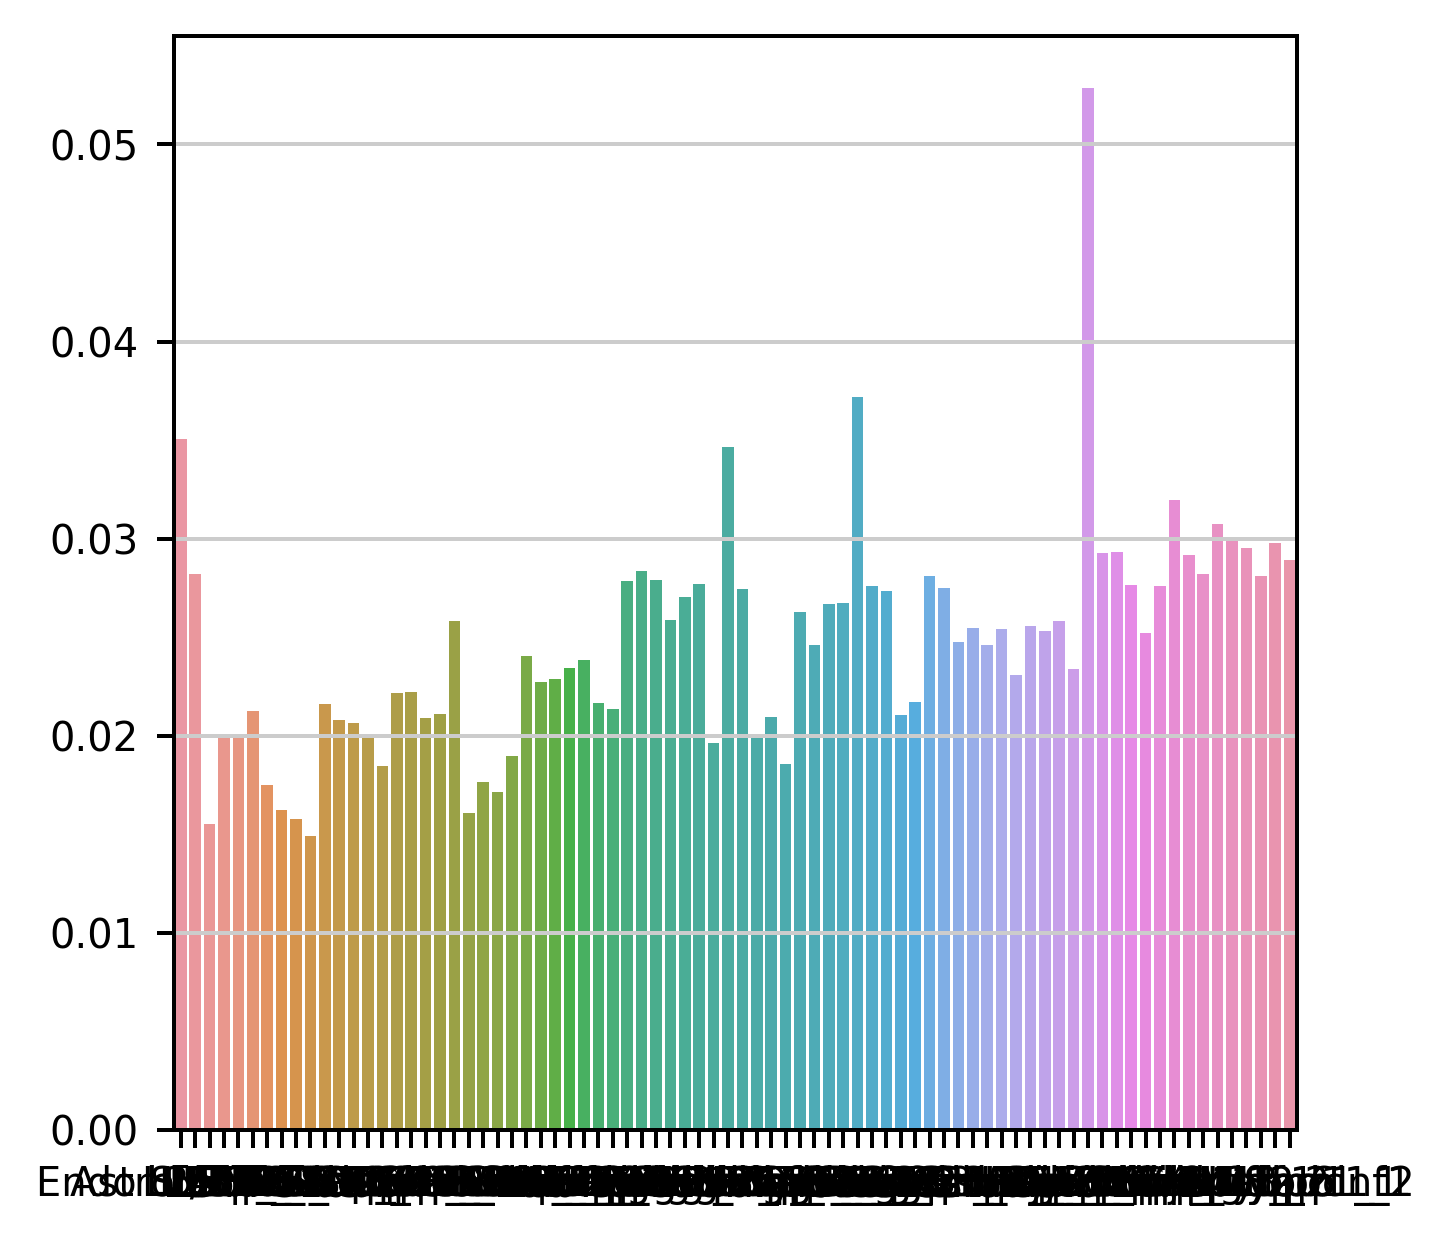

[('VLMC Kcnj8', 0.05287989),
 ('SMC', 0.037172068),
 ('Astro Aqp4', 0.035043087),
 ('OPC Pdgfra', 0.034672722),
 ('Vip Crispld2', 0.03194266),
 ('Vip Htr1f_2', 0.030729687),
 ('Vip Igfbp6', 0.030000683),
 ('Vip Mybpc1_2', 0.02976025),
 ('Vip Lypd1', 0.029507678),
 ('Vip Cbln4_1', 0.029331908),
 ('Vip C1ql1', 0.029266356),
 ('Vip Gpc3', 0.029154774),
 ('Vip Serpinf1', 0.028939422),
 ('Lamp5 Lhx6', 0.028367339),
 ('Vip Htr1f_1', 0.028230257),
 ('Endo Slc38a5_1', 0.02820137),
 ('Sst Calb2', 0.028109316),
 ('Vip Mybpc1_1', 0.028091326),
 ('Lamp5 Pax6', 0.027904905),
 ('Lamp5 Egln3_2_1', 0.027836667),
 ('Lamp5 Slc35d3_1', 0.027701836),
 ('Vip Cbln4_2', 0.027638366),
 ('Sncg_1', 0.027612152),
 ('Vip Col14a1', 0.027610747),
 ('Sst Chodl', 0.027486382),
 ('Oligo Enpp6_1', 0.027438149),
 ('Sncg_2', 0.02732346),
 ('Lamp5 Pdlim5_2', 0.027017185),
 ('Pvalb Vipr2', 0.026733713),
 ('Pvalb Reln', 0.026699144),
 ('Pvalb Calb1', 0.02629803),
 ('Lamp5 Pdlim5_1', 0.025883429),
 ('Sst Pvalb Etv1', 0.02584

In [14]:
# Make sure the expression level of selected genes are not too high. 
# Plot the fraction of counts of selected genes in each cluster.
# Emperically, the detection efficiency is very good if the fraction is below 0.03.
cluster_labels = np.unique(adata_raw.obs['cluster_label'])
cluster_exp_fraction = []

for cl in cluster_labels:
    X_cluster = adata_raw.X[adata_raw.obs['cluster_label'] == cl]
    total_gene_count = np.sum(X_cluster)
    selected_gene_count = np.sum(X_cluster[:, adata_raw.var.index.isin(selected_genes)])

    cluster_exp_fraction.append(selected_gene_count / total_gene_count)
    
sns.barplot(x=cluster_labels, y=cluster_exp_fraction)
plt.show()

cell_type_and_expression = list(zip(cluster_labels, cluster_exp_fraction))
sorted(cell_type_and_expression, reverse=True, key=lambda x:x[1])

# Save the result

In [15]:
# Save the selected genes
df = adata.var[adata.var.index.isin(selected_genes)][['gene_ids']]
df.to_csv(selected_genes_file)